# Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
import os

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 6500  # Number of samples to train on.

In [ ]:
dataset = '/content/drive/MyDrive/Colab Notebooks/EECE 693/Assignment4/Dataset'
input_texts = []
target_texts = []
input_words = set()
target_words = set()
sample = 0
with open(dataset+'/ara.txt') as f:
    target_words.add("<sos>")
    target_words.add("<eos>")
    for line in f:
        sample += 1
        if sample == num_samples:
            break
        engText, araText, _ = line.split('\t')
        input_texts.append(engText)
        # We use <sos> as the "start of sequence" character
        # for the targets, and "<eos>" as "end of sequence" character.
        target_texts.append("<sos> " + araText + " <eos>")
        for word in engText.split():
            if word not in input_words:
                input_words.add(word)
        for word in araText.split():
            if word not in target_words:
                target_words.add(word)

for i in range(3):
    print(f"English: {input_texts[i]}")
    print(f"Arabic: {target_texts[i]}")
    print("---------------------------------------------------")

for i in range(1, 4):
    print(f"English: {input_texts[-i]}")
    print(f"Arabic: {target_texts[-i]}")
    print("---------------------------------------------------")

English: Hi.
Arabic: <sos> مرحبًا. <eos>
---------------------------------------------------
English: Run!
Arabic: <sos> اركض! <eos>
---------------------------------------------------
English: Help!
Arabic: <sos> النجدة! <eos>
---------------------------------------------------
English: Tom wished he hadn't looked.
Arabic: <sos> تمنى توم لو أنه لم يرى. <eos>
---------------------------------------------------
English: Tom will need a lot of help.
Arabic: <sos> سوف يحتاج توم الكثير من المساعدة. <eos>
---------------------------------------------------
English: Tom was indicted last month.
Arabic: <sos> تم اتهام توم الشهر الماضي. <eos>
---------------------------------------------------


In [ ]:
input_words = sorted(list(input_words))                             # english lexicon -> encoder
num_encoder_tokens = len(input_words)                               # size of english lexicon -> encoder
max_encoder_seq_length = max([len(txt) for txt in input_texts])     # max text size in english lexicon -> encoder
target_words = sorted(list(target_words))                           # arabic lexicon -> decoder
num_decoder_tokens = len(target_words)                              # size of arabic lexicon -> decoder
max_decoder_seq_length = max([len(txt) for txt in target_texts])    # max text size in arabic lexicon -> decoder


#Vocabulary

In [ ]:
vectorizer_eng = TextVectorization(max_tokens=num_encoder_tokens, output_sequence_length=max_encoder_seq_length)
text_ds_eng = tf.data.Dataset.from_tensor_slices(input_texts)
vectorizer_eng.adapt(text_ds_eng)
voc_eng = vectorizer_eng.get_vocabulary()
word_index_eng = dict(zip(voc_eng, range(len(voc_eng))))


vectorizer_ara = TextVectorization(max_tokens=num_decoder_tokens, output_sequence_length=max_decoder_seq_length)
text_ds_ara = tf.data.Dataset.from_tensor_slices(target_texts).batch(128)
vectorizer_ara.adapt(text_ds_ara)
voc_ara = vectorizer_ara.get_vocabulary()
word_index_ara = dict(zip(voc_ara, range(len(voc_ara))))

reverse_input_char_index = dict((i, char) for char, i in word_index_eng.items())
reverse_target_char_index = dict((i, char) for char, i in word_index_ara.items())

In [ ]:
path_to_glove_file = "/content/drive/MyDrive/Colab Notebooks/EECE 693/Assignment4/glove/glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

num_encoder_tokens = len(voc_eng) + 2
embedding_dim = 300

embedding_matrix_eng = np.zeros((num_encoder_tokens, embedding_dim))
for word, i in word_index_eng.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_eng[i] = embedding_vector

num_decoder_tokens = len(voc_ara) + 2

del embeddings_index

In [ ]:
X = vectorizer_eng(np.array([[s] for s in input_texts])).numpy()
y = vectorizer_ara(np.array([[s] for s in target_texts])).numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=32)

col = np.zeros(y_train.shape[0]).reshape(y_train.shape[0], 1)
shifted_y_train = np.append(y_train[:,1:], col, axis=1)

del col
del X
del y

decoder_target_data_shifted = np.zeros(
    (len(shifted_y_train), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, sample in enumerate(shifted_y_train):
    for j, word_index in enumerate(sample):
        decoder_target_data_shifted[i, j, int(word_index)] = 1.0

del shifted_y_train

# Model

In [ ]:
from tensorflow.keras.layers import Embedding

encoder_embedding_layer = Embedding(
    num_encoder_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_eng),
    trainable=False,
)

decoder_embedding_layer = Embedding(
    num_decoder_tokens,
    embedding_dim,
    trainable=True,
)

encoder_inputs = keras.Input(shape=(None, ))
encoder_embedded_sequences = encoder_embedding_layer(encoder_inputs)
encoder = keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder(encoder_embedded_sequences)
encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(None, ))
decoder_embedded_sequences = decoder_embedding_layer(decoder_inputs)
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedded_sequences, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.fit(
    [X_train, y_train],
    decoder_target_data_shifted,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
)
# Save model
model.save("/content/drive/MyDrive/Colab Notebooks/EECE 693/Assignment4/s2s_manual_shifted_v4")


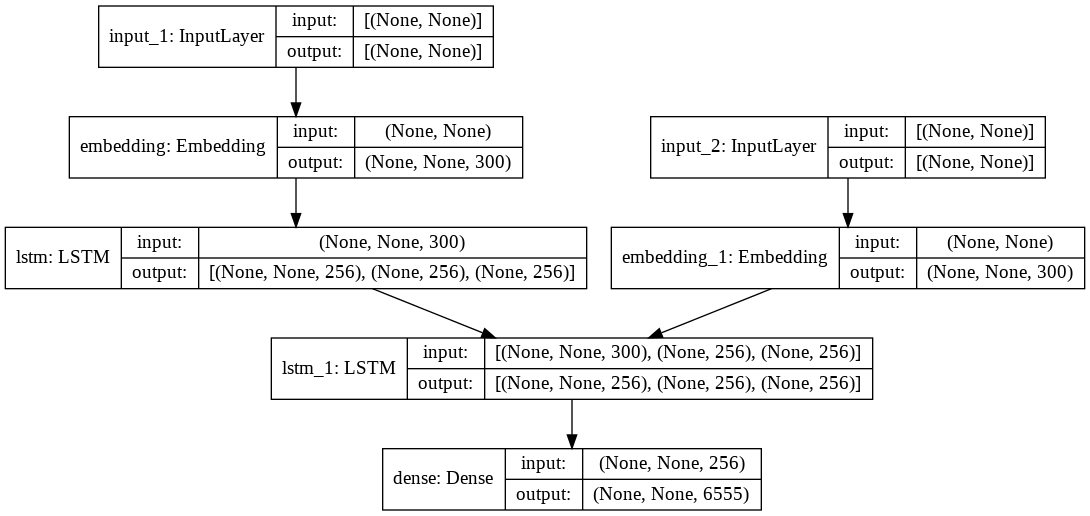

In [4]:
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EECE 693/Assignment4/s2s_manual_shifted_v3")

model.save_weights("/content/drive/MyDrive/Colab Notebooks/EECE 693/Assignment4/model.h5")
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# Evaluation using train data

In [ ]:
model1 = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EECE 693/Assignment4/s2s_manual_shifted_v3")

In [ ]:
ori = ""
for sample in X_train[50:100]:
    for e in sample:
        ori += reverse_input_char_index[e] + " "
    ori += '\n'
ori = ori.split('\n')

gT = []
for sample in y_train[50:100]:
    true_sample = []
    for e in sample:
        if reverse_target_char_index[e] == 'sos':
            continue
        true_sample.append(reverse_target_char_index[e])
        if reverse_target_char_index[e] == 'eos':
            break
    gT.append(' '.join(true_sample))

pred = model1.predict([X_train[50:100], y_train[50:100]])
predictions = []
for sample in pred:
    sampled_token_index = np.argmax(sample, axis=1)
    predicted_sample = []
    for e in sampled_token_index:
        predicted_sample.append(reverse_target_char_index[e])
        if reverse_target_char_index[e] == 'eos':
            break
    predictions.append(' '.join(predicted_sample))

for i in range(len(gT[:10])):
    print(f"Original: {ori[i]} \nGround Truth: {gT[i]} \nPrediction: {predictions[i]}")
    print()

Original: i know how old you are                        
Ground Truth: أعرف كم عمرك eos 
Prediction: أعرف كم عمرك eos

Original: how tall you are                          
Ground Truth: ما أطولك eos 
Prediction: ما أطول eos

Original: she turned eightyone                           
Ground Truth: أصبح عمرها واحداً و ثمانين سنة eos 
Prediction: أصبح عمرها واحداً و ثمانين سنة eos

Original: when is school over                          
Ground Truth: متى ينتهي الدوام المدرسيّ؟ eos 
Prediction: متى ينتهي الدوام المدرسيّ؟ eos

Original: whose books are those                          
Ground Truth: لمن هذه الكتب؟ eos 
Prediction: لمن هذه الكتب؟ eos

Original: we grew up together                          
Ground Truth: نشأنا سويّا eos 
Prediction: نشأنا سويّا eos

Original: i didnt know she was ill                        
Ground Truth: لم أكن على علم بمرضها eos 
Prediction: لم أكن على علم بمرضها eos

Original: meat is expensive nowadays                          
Ground Truth: ثمن اللحم باهظ في

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoother = SmoothingFunction()

bleu_scores = corpus_bleu(predictions, gT)*100
print(f"Bleu Score: {bleu_scores}%")

Bleu Score: 90.42288524110901%


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


# Evaluation using test data

In [ ]:
model1 = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EECE 693/Assignment4/s2s_manual_shifted_v3")
print(model1.summary())

In [ ]:
ori = ""
for sample in X_test[:100]:
    for e in sample:
        ori += reverse_input_char_index[e] + " "
    ori += '\n'
ori = ori.split('\n')

gT = []
for sample in y_test[:100]:
    true_sample = []
    for e in sample:
        if reverse_target_char_index[e] == 'sos':
            continue
        true_sample.append(reverse_target_char_index[e])
        if reverse_target_char_index[e] == 'eos':
            break
    gT.append(' '.join(true_sample))

pred = model1.predict([X_test[:100], y_test[:100]])
predictions = []
for sample in pred:
    sampled_token_index = np.argmax(sample, axis=1)
    predicted_sample = []
    for e in sampled_token_index:
        predicted_sample.append(reverse_target_char_index[e])
        if reverse_target_char_index[e] == 'eos':
            break
    predictions.append(' '.join(predicted_sample))

for i in range(len(gT[:10])):
    print(f"Original: {ori[i]} \nGround Truth: {gT[i]} \nPrediction: {predictions[i]}")
    print()

Original: you reap what you sow                         
Ground Truth: من زرع حصد eos 
Prediction: سوف تريد ماذا ما                                                         

Original: whenever i call he is out                        
Ground Truth: كلما أتصل به ، يكون قد خرج eos 
Prediction: لقد أبي منذ eos

Original: i was too happy to sleep                        
Ground Truth: لقد كنت مسرورا جدا لكى أنام eos 
Prediction: كنت وقعت هنا الكثير هنا eos

Original: this desk is mine                          
Ground Truth: هذا مكتبي eos 
Prediction: هذا المكتب eos

Original: he is ill                           
Ground Truth: إنه مريض eos 
Prediction: هو مريض eos

Original: it is unfortunately true                          
Ground Truth: مع الأسف إن ذلك صحيح eos 
Prediction: إن ذلك ذلك ذلك eos

Original: i need that medicine                          
Ground Truth: أحتاج هذا العلاج eos 
Prediction: أحتاج لهذا eos

Original: please look at me                          
Ground Truth: انظر إليّ م

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoother = SmoothingFunction()

bleu_scores = corpus_bleu(predictions, gT)*100
print(f"Bleu Score: {bleu_scores}%")

Bleu Score: 82.10753934666192%


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


# Inference using train data

In [ ]:
'''
Generate the 5 random sentences to translate from the X_test list
'''
from random import randint

sentences_index = set()
while len(sentences_index) != 5:
    sentences_index.add(randint(0, len(y_test)-1))


In [ ]:
'''
Encode the input and get the states from it
Set the first "Word" input of the decoder to our start of sentence token "sos"
Predict the next word, check if it is the end of sentence token "eos" ot if we 
reached maximum length to end the prediction.
If we do not need to end our prediction, update the input states of the next
prediction, which will be used as initial values for the lstm layer, to the 
values of the current lstm states.
Input the new states ("current") in addition to the predicted word and repeat  
'''
def decode_sequence(input_seq):
    states_value = inf_encoder_model.predict(np.expand_dims(input_seq, axis=0))

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word_index_ara["sos"]

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = inf_decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens, axis=2)[0][0]
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        if sampled_char == "eos" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]
    return decoded_sentence

In [ ]:
model = model1

'''
Use same encoder as the model, but output the states of the lstm layer
'''
inf_encoder_inputs = model.input[0]
inf_encoder_embedded_sequences = model.layers[2](inf_encoder_inputs)
inf_encoder_outputs, state_h, state_c = model.layers[4](inf_encoder_embedded_sequences)
inf_encoder_states = [state_h, state_c]
inf_encoder_model = keras.Model(inf_encoder_inputs, inf_encoder_states)

'''
use same decoder as the model, but take as input the output states of the encoder
in addition to the normal input which in our case is going to be the previous
predicted word. Set the states of the first lstm layer to the output states of 
the encoder model. Model outputs also its own states which will then be used as
initial state for the lstm layer
'''

inf_decoder_inputs = model.input[1]
inf_decoder_state_input_h = keras.Input(shape=(latent_dim,))
inf_decoder_state_input_c = keras.Input(shape=(latent_dim,))
inf_decoder_states_inputs = [inf_decoder_state_input_h, inf_decoder_state_input_c]
inf_decoder_embedded_sequences = model.layers[3](inf_decoder_inputs)
inf_decoder_outputs, state_h2, state_c2  = model.layers[5](inf_decoder_embedded_sequences, initial_state=inf_decoder_states_inputs)
inf_decoder_states2 = [state_h2, state_c2]
inf_decoder_outputs2 = model.layers[6](inf_decoder_outputs)

inf_decoder_model = keras.Model(
    [inf_decoder_inputs] + inf_decoder_states_inputs,
    [inf_decoder_outputs2] + inf_decoder_states2)


In [ ]:
for index in sentences_index:
    input_seq = X_train[index]
    print("\nInput Sequence: ", end="")
    for e in input_seq:
        print(reverse_input_char_index[e], end=" ")
    print("\nTrue translation: ", end="")
    for e in y_train[index]:
        print(reverse_target_char_index[e], end=" ")
    output = decode_sequence(input_seq)
    print("\nOutput Sequence: ", output)
    print("################################################")


Input Sequence: who said that                          
True translation: sos من قال هذا؟ eos                                                         
Output Sequence:   من قال هذا؟ eos
################################################

Input Sequence: play with me                          
True translation: sos العب معي eos                                                          
Output Sequence:   العب معي eos
################################################

Input Sequence: how much did you win                        
True translation: sos كم رَبِحتَ؟ eos                                                          
Output Sequence:   كم رَبِحتَ؟ eos
################################################

Input Sequence: i would do anything for tom                       
True translation: sos سأفعل أيّ شيء لِتوم eos                                                        
Output Sequence:   سأفعل أيّ شيء لِتوم eos
################################################

Input Sequence: were against 

# Inference using test data

In [ ]:
'''
Generate the 5 random sentences to translate from the X_test list
'''
from random import randint

sentences_index = set()
while len(sentences_index) != 5:
    sentences_index.add(randint(0, len(y_test)-1))


In [ ]:
'''
Encode the input and get the states from it
Set the first "Word" input of the decoder to our start of sentence token "sos"
Predict the next word, check if it is the end of sentence token "eos" ot if we 
reached maximum length to end the prediction.
If we do not need to end our prediction, update the input states of the next
prediction, which will be used as initial values for the lstm layer, to the 
values of the current lstm states.
Input the new states ("current") in addition to the predicted word and repeat  
'''
def decode_sequence(input_seq):
    states_value = inf_encoder_model.predict(np.expand_dims(input_seq, axis=0))

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word_index_ara["sos"]

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = inf_decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens, axis=2)[0][0]
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        if sampled_char == "eos" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]
    return decoded_sentence

In [ ]:
model = model1

'''
Use same encoder as the model, but output the states of the lstm layer
'''
inf_encoder_inputs = model.input[0]
inf_encoder_embedded_sequences = model.layers[2](inf_encoder_inputs)
inf_encoder_outputs, state_h, state_c = model.layers[4](inf_encoder_embedded_sequences)
inf_encoder_states = [state_h, state_c]
inf_encoder_model = keras.Model(inf_encoder_inputs, inf_encoder_states)

'''
use same decoder as the model, but take as input the output states of the encoder
in addition to the normal input which in our case is going to be the previous
predicted word. Set the states of the first lstm layer to the output states of 
the encoder model. Model outputs also its own states which will then be used as
initial state for the lstm layer
'''

inf_decoder_inputs = model.input[1]
inf_decoder_state_input_h = keras.Input(shape=(latent_dim,))
inf_decoder_state_input_c = keras.Input(shape=(latent_dim,))
inf_decoder_states_inputs = [inf_decoder_state_input_h, inf_decoder_state_input_c]
inf_decoder_embedded_sequences = model.layers[3](inf_decoder_inputs)
inf_decoder_outputs, state_h2, state_c2  = model.layers[5](inf_decoder_embedded_sequences, initial_state=inf_decoder_states_inputs)
inf_decoder_states2 = [state_h2, state_c2]
inf_decoder_outputs2 = model.layers[6](inf_decoder_outputs)

inf_decoder_model = keras.Model(
    [inf_decoder_inputs] + inf_decoder_states_inputs,
    [inf_decoder_outputs2] + inf_decoder_states2)


In [ ]:
for index in sentences_index:
    input_seq = X_test[index]
    print("\nInput Sequence: ", end="")
    for e in input_seq:
        print(reverse_input_char_index[e], end=" ")
    print("\nTrue translation: ", end="")
    for e in y_test[index]:
        print(reverse_target_char_index[e], end=" ")
    output = decode_sequence(input_seq)
    print("\nOutput Sequence: ", output)
    print("################################################")


Input Sequence: my aim is to be a doctor                      
True translation: sos حلمي أن أكون طبيباً eos                                                        
Output Sequence:   هدفي أن أصبح طبيباً eos
################################################

Input Sequence: do you believe that                         
True translation: sos هل تصدّقين ذلك؟ eos                                                         
Output Sequence:   افعل ما تريد eos
################################################

Input Sequence: i waited for you                         
True translation: sos إنتظرتك eos                                                           
Output Sequence:   لقد حاولت عليّ أن eos
################################################

Input Sequence: i am in the house                        
True translation: sos أنا في المنزل eos                                                         
Output Sequence:   أنا في لندن eos
################################################

Input Sequenc